## Quantum Computing

**Integrantes**: Jhon Stewar Rayo Mosquera - j.rayom@uniandes.edu.co

# Sudoku

A $2x2$ sudoku consists of a square matrix $A_{2x2}$ where we can use any two symbols $x$ and $y$ such that no row or column has duplicate elements.

We can represent the matrix $A$ with $4$ bits of information where each bit $b_i$ corresponds to one of the four positions of the Sudoku and equals $0$ if the symbol maps to $x$. Otherwise, the bit equals $1$.

The following matrix illustrates this idea for $x = p$ and $y = q$

$$
\begin{pmatrix}
p & q\\
q & p\\
\end{pmatrix}
=
\begin{pmatrix}
0 & 1\\
1 & 0\\
\end{pmatrix}
$$

We can then use a bit string to represent each possible state $s$ by concatenating each value in the mapped matrix as such

$$
s = a_{00} \cdot a_{01} \cdot a_{10} \cdot a_{11}
$$

For the above matriz, $s = 0110$

## Classical circuit

A classical computer can naively brute force the search space which consists of $N = 2^4 = 16$ possible permutations of $A$, and find the valid solutions in $O(N)$ time by veryfying whether a given permutation satisfies the requirements. (*i.e*, no row or column has duplicate elements).

In [1]:
# A simple classical function to verify whether a bit string corresponds to a sudoku solution
def f(s):
    return s[0] == s[3] and s[1] == s[2] and s[0] != s[1] and s[2] != s[3]

In [2]:
# Brute force all search space and find solutions to sudoku using f
n = 4
N = 2**n

for i in range(N):
    s = bin(i)[2:].zfill(n)
    if f(s):
        print(s)

0110
1001


There are ony two solutions to a $2x2$ Sudoku!

Now, an interesting question arises. Can we use $f$ to find these solutions faster? Turns out we actually can do this in $O(\sqrt N)$ with quantum computers.

## Quantum circuit

We will first need to convert $f$ to a valid quantum circuit. This requires that $f$ is a reversible function. That is, $f(f(s_i)) = s_i$ for all $i$.

For a valid sudoku solution, notice that the first and last bits of $s$ have to be equal. Similarly, the second and third bits also need to be equal. Hence, we can design the circuit as follows. 

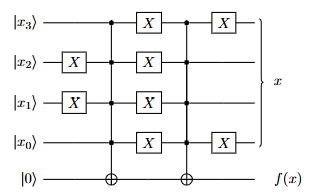

In this curcuit we are using four qubits $x_i$, and one output qubit for the value of $f(x)$ which equals $1$ if and only if the bit string $x$ represents a valid solution. Notice that the state of the input qubits does not change, and we can use this to reverse the circuit.

In [3]:
# importing Qiskit
from qiskit import QuantumCircuit
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import MCMT

# import basic plot tools
from qiskit.visualization import plot_histogram

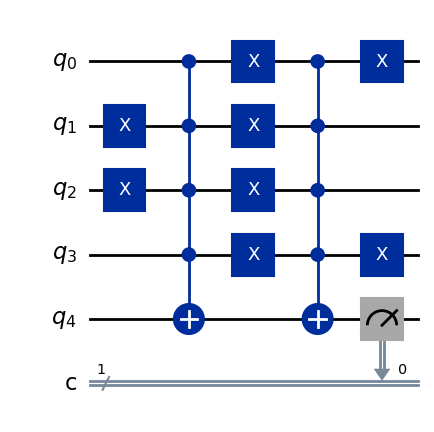

In [4]:
# Let us implement this quantum circuit with qiskit
def quantum_f(init_state, add_measurement=True):
    c = init_state

    # Not gate applied on q1 and q2
    c.x([1, 2])
    # Multicontrolled-not gate applied on all qubits
    c.mcx(list(range(4)), 4, None, mode='advanced')
    # Not gate applied on all input qubits
    c.x(range(4))
    # Multicontrolled-not gate applied on all qubits
    c.mcx(list(range(4)), 4, None, mode='advanced')
    # Not gate applied on q0 and q3
    c.x([0, 3])
    
    if add_measurement:
        # Measure the output qubit
        c.measure(4, 0)
    
    return c

c = quantum_f(QuantumCircuit(n+1, 1))
c.draw(output='mpl')

In [5]:
# Let us implement the classical brute force approach using the quantum circuit f

# Brute force all search space and find solutions to sudoku using quantum reversible f
for i in range(N):
    qc = QuantumCircuit(n+1, 1)
    
    s = bin(i)[2:].zfill(n)
    
    # Create the input state
    for i, b in enumerate(s):
        if b == '1':
            qc.x(i)
       
    # Append the quantum circuit f to verify valid solutions
    qc = quantum_f(qc)

    # Run the algorithm on a quantum simulator
    sampler = StatevectorSampler()
    job_sampler = sampler.run([qc], shots=1024)

    result_sampler = job_sampler.result()[0].data.c.get_counts()
    
    # Output the input state if the function f returned 1
    if result_sampler.get('1'):
        print(s)

0110
1001


As we can see, we have obtained the same result with the quantum function $f$ to determine if a bit string represents a valid solution, and we are ready to see how we can find the sudoku solutions!

## Grover's Algorithm

We will use *Grover's* algorithm as a subroutine to find $x$ such that $f(x) = 1$ in $O(\sqrt N)$ queries. The states that satisfy the former condition will be part of the set $\omega$. *Note: We actually know that $0110 \in \omega$ and $1001 \in \omega$ as we demonstrated above.*

*Grover's* algorithm consists of three steps: state preparation, the oracle, and the difussion operator.

### State preparation

The state preparation consists of creating a superposition of all the possible solutions. In this case, we know $4$ qubits can be used to represent all the states $s$. Hence, we need to create a superposition of $4$ qubits using Hadamard gates. The state of these qubits can be determined by

$$
|s\rangle = \frac{1}{4} \sum_{x = 0}^{15} | x \rangle
$$

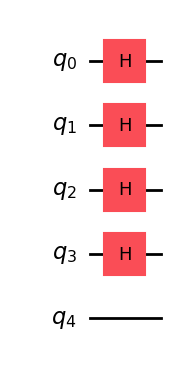

In [6]:
# Let us start with the state preparation
circuit = QuantumCircuit(n+1)
# Let us put all input qubits in the state of equal superposition
circuit.h(range(4))
circuit.draw(output='mpl')

## Oracle

Secondly, we need to create an oracle that will be used to mark the correct state/s $\omega$. In fact, we have already done part of this!.

We can use $f$ to implement the oracle and we just need to ensure that the oracle can mark the solution with a negative phase. That is, the oracle $U_f$ can be defined as follows.

$$
U_f|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \notin \omega \\
-|x\rangle \quad \text{if} \; x \in \omega \\
\end{aligned}
$$

$$
U_f|x\rangle = (-1)^{f(x)}|x\rangle
$$

To do this, we simply need to ensure that the output qubit is initialized to $|-\rangle$.

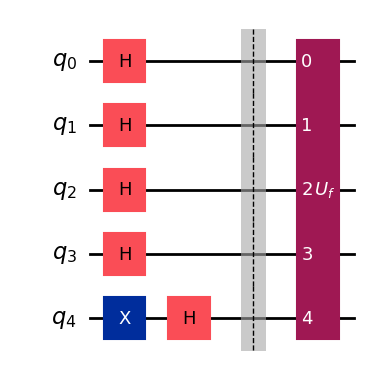

In [7]:
# The minus state can be created by using a NOT gate followed by a Hadamard gate
circuit.x(4)
circuit.h(4)

def append_oracle():
    # Let us create the oracle Uf by using the circuit f with the output qubit initialized to the bell state |->
    oracle = QuantumCircuit(n+1)
    # Append circuit f
    oracle = quantum_f(oracle, add_measurement=False)
    # Name the oracle f
    oracle.name = '$U_f$'
    # append the oracle to our circuit
    circuit.append(oracle, range(5))

# Let us visualize the circuit so far
circuit.barrier()
append_oracle()
circuit.draw(output='mpl')

Now  $q_4$ will output the state $|-\rangle$, and as a result of the phase kickback, the states in $\omega$ will have a negative amplitude.

## Difusser

Now that we have marked the correct answers with a negative phase, the diffuser operator $U_s$ is used to amplify the amplitude of the correct answers $\omega$, while decreasing the amplitudes of all other states.

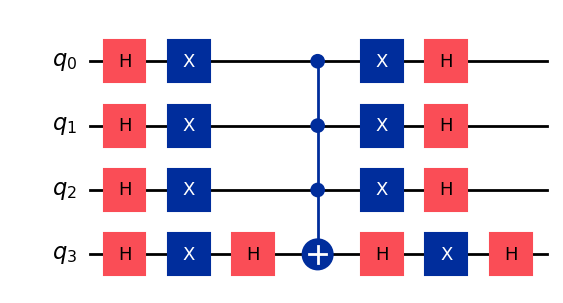

In [8]:
def get_difusser():
    # Let us create the diffuser by using X-gate layers, and a multicontrolled z-gate sandwiched between 
    # two layers of Hadamard gates
    diff = QuantumCircuit(n)
    # Apply first layer of Hadamard gates
    diff.h(range(4))
    # Apply X-gate layer
    diff.x(range(4))
    # Apply multicontrolled z-gate
    diff.h(3)
    diff.mcx(list(range(3)), 3)  # multi-controlled-toffoli
    diff.h(3)
    # Apply x-gate layer
    diff.x(range(4))
    # Apply final layer of Hadamard gates
    diff.h(range(4))
    # Name the diffuser
    diff.name = '$U_s$'
    return diff

diff = get_difusser()
diff.draw(output='mpl')

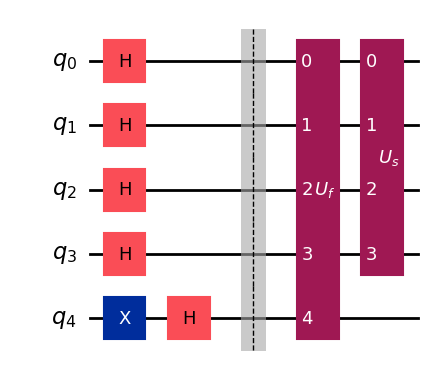

In [9]:
# Let's append the diffuser to our circuit
def append_diffuser():
    circuit.append(diff, range(4))

append_diffuser()
circuit.draw(output='mpl')

Geometrically, we have amplified the magnitude of the states in $\omega$. But how many times do we need to do this so that the probability of collapsing to one of the states in $\omega$ is close to $1$? *Grover's algorithm* establishes that we only need to run the oracle/diffuser $\lfloor\frac{\pi}{4}\sqrt{\frac{N}{|\omega|}}\rfloor$. For this scenario this value would be $\lfloor\frac{\pi}{4}\sqrt{\frac{16}{2}}\rfloor = 2$

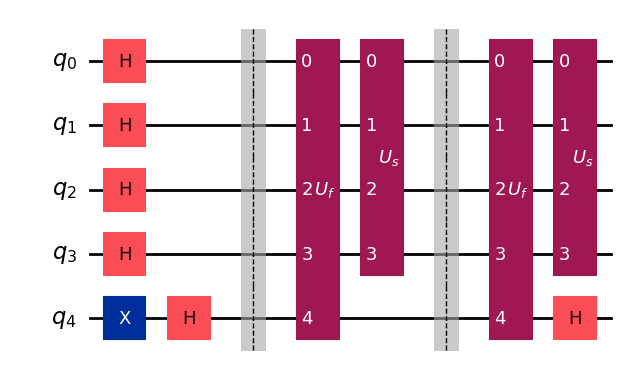

In [10]:
# Let us add another iteration of grovers operator
circuit.barrier()
append_oracle()
append_diffuser()

# Let us collapse the minus state to 1 by reversing the hadamard gate on the ancilla qubit
circuit.h(4)

circuit.draw(output='mpl')

It's now time to run the algorithm!

Let's first run it on a simulator

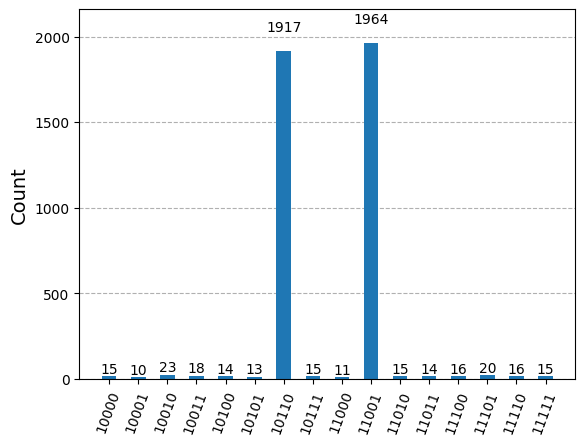

In [11]:
circuit.measure_all()

sampler = StatevectorSampler()
job_sampler = sampler.run([circuit], shots=4096)

result_sampler = job_sampler.result()[0].data.meas.get_counts()

plot_histogram(result_sampler)


As we can see, the states $0110$ and $1001$ (ignoring the first auxiliary bit) correspond to the valid sudoku solutions and it only took $2$ calls to the function $f$ instead of $16$ that would take on a classical computer.

## Real Quantum Computer

Let's now run our algorithm in an actual quantum device hosted by IBM.

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler

In [13]:
# Let's save our credentials
service = QiskitRuntimeService(channel="ibm_quantum", token="<token>")

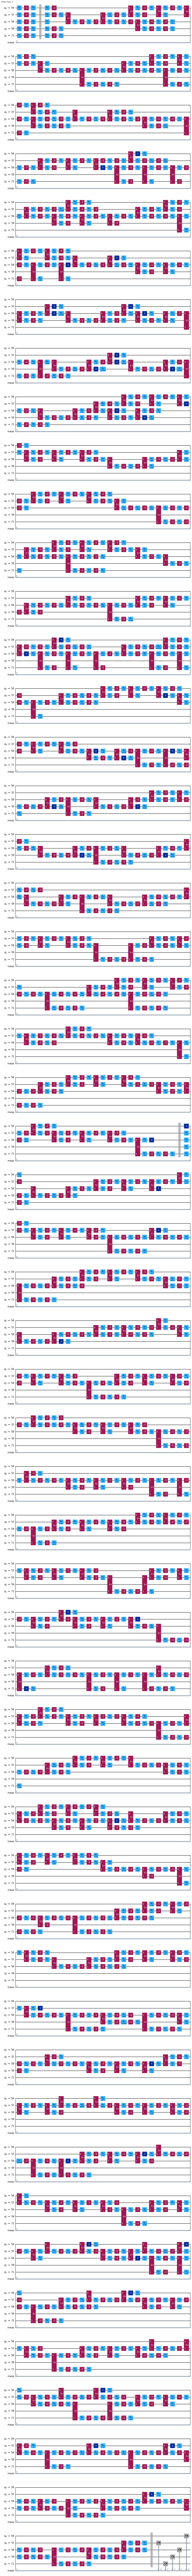

In [14]:
# Use the quantum computer that's least busy at the moment
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_circuit = pm.run(circuit)
 
isa_circuit.draw('mpl', idle_wires=False)

In [15]:
# Construct the Sampler instance.
sampler = Sampler(backend)
 
job = sampler.run([isa_circuit], shots=10000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cterzwz1zwrg008cmt1g
>>> Job Status: QUEUED


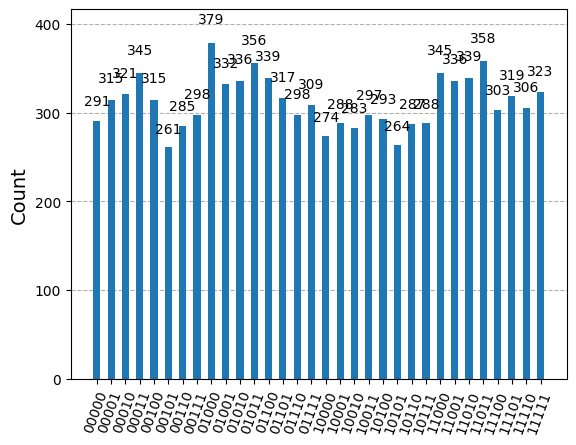

In [16]:
result = job.result()
plot_histogram(result[0].data.meas.get_counts())

Unfortunately, the transpiled circuit is not only too complex, but also real quantum systems still have noise which impacts our calculations. We can also observe the same circuit implemented on IBM Composer where the simulated amplitudes are correct.

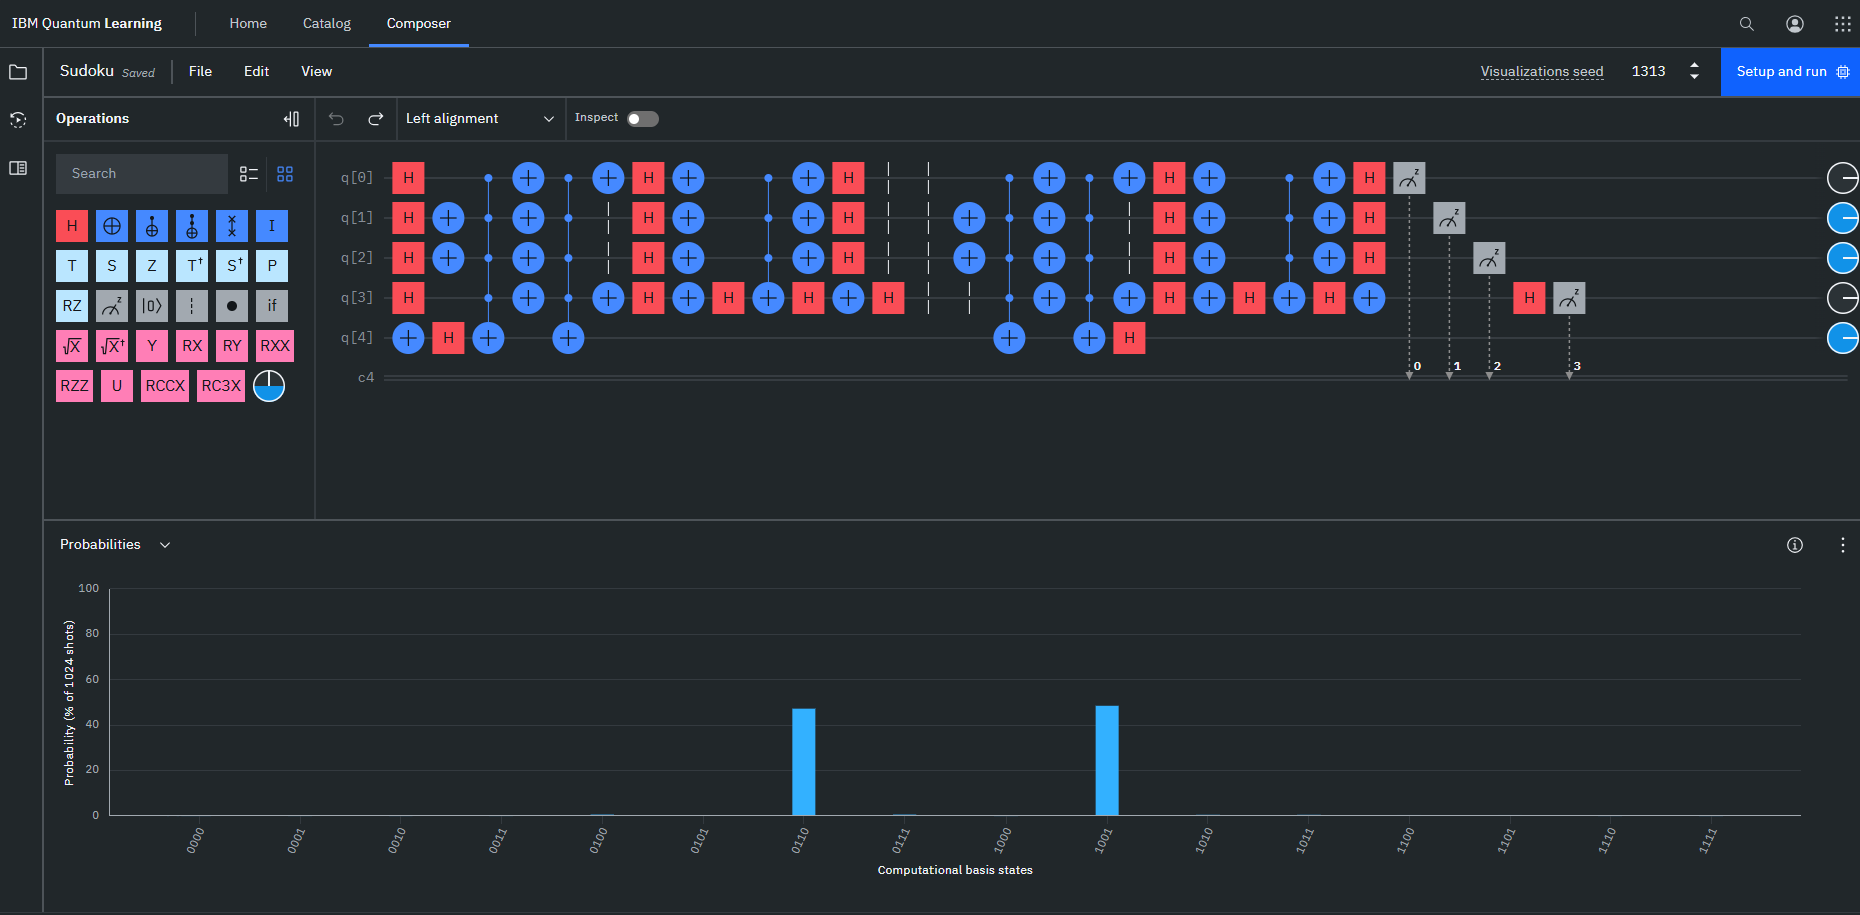